In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/My Drive/ModMonuSeg.zip"

Archive:  /content/gdrive/My Drive/ModMonuSeg.zip
   creating: ModMonuSeg/
   creating: ModMonuSeg/Test/
   creating: ModMonuSeg/Test/GroundTruth/
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH0.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH1.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH10.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH11.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH12.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH13.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH14.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH15.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH16.png  
 extracting: ModMonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask-PCH17.p

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
# print(tf.version)

Using TensorFlow backend.


In [0]:
# Set some parameters
im_width = 256
im_height = 256
border = 5

In [0]:
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder

  im_width, im_height = im_shape


  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))

  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

  # tqdm is used to display the progress bar
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

In [7]:
# X_test, y_test = get_images("ModMonuSeg/Test/", (im_width, im_height), gt_extension='png')
X, y = get_images("/content/ModMonuSeg/Training/", (im_width, im_height))

No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
# Define Some metrics
## Dice Score
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
## F1 Score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef, f1])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 256, 256, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [15]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))



Train on 972 samples, validate on 108 samples
Epoch 1/50
972/972 [==============================] - 30s 31ms/step - loss: 0.4151 - acc: 0.8211 - dice_coef: 0.5605 - f1: 0.6885 - val_loss: 0.3606 - val_acc: 0.8459 - val_dice_coef: 0.5925 - val_f1: 0.6454

Epoch 00001: val_loss improved from inf to 0.36064, saving model to model-unet.h5
Epoch 2/50
972/972 [==============================] - 17s 17ms/step - loss: 0.3046 - acc: 0.8791 - dice_coef: 0.6529 - f1: 0.7814 - val_loss: 0.2845 - val_acc: 0.8833 - val_dice_coef: 0.6687 - val_f1: 0.7755

Epoch 00002: val_loss improved from 0.36064 to 0.28449, saving model to model-unet.h5
Epoch 3/50
972/972 [==============================] - 17s 17ms/step - loss: 0.2781 - acc: 0.8876 - dice_coef: 0.6737 - f1: 0.7951 - val_loss: 0.2743 - val_acc: 0.8876 - val_dice_coef: 0.6810 - val_f1: 0.7839

Epoch 00003: val_loss improved from 0.28449 to 0.27426, saving model to model-unet.h5
Epoch 4/50
972/972 [==============================] - 17s 17ms/step - l

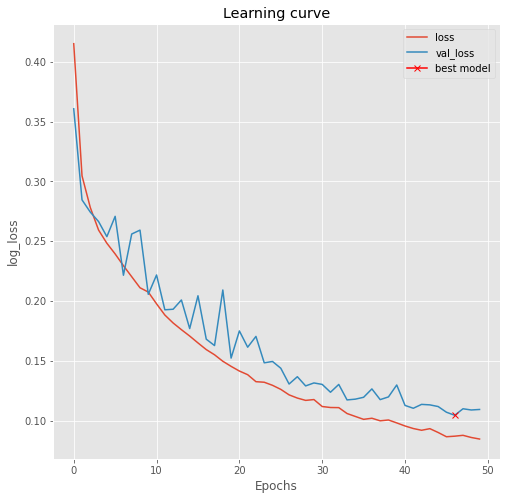

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

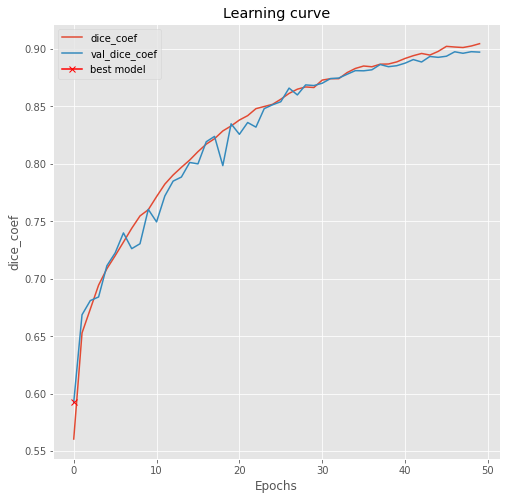

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();
plt.savefig("unet_dice_coef.png")

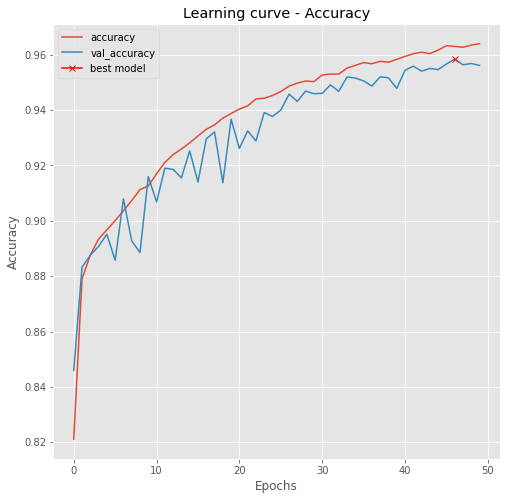

In [32]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - Accuracy")
plt.plot(results.history["acc"], label="accuracy")
plt.plot(results.history["val_acc"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

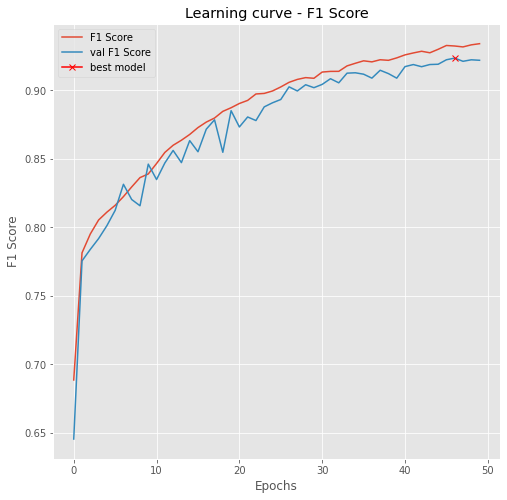

In [34]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - F1 Score")
plt.plot(results.history["f1"], label="F1 Score")
plt.plot(results.history["val_f1"], label="val F1 Score")
plt.plot( np.argmax(results.history["val_f1"]), np.max(results.history["val_f1"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend();

In [18]:
X_test, y_test = get_images("ModMonuSeg/Test/", (im_width, im_height), gt_extension='png')

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [19]:
# load the best model
model.load_weights('model-unet.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X, y, verbose=1)

1080/1080 [==============================] - 7s 6ms/step


[0.07425093369351493,
 0.9688491958158988,
 0.9144358511324282,
 0.9429700754306934]

In [30]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score,  dice_score = model.evaluate(X_train, y_train, verbose=1)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Dice_score:", dice_score)

972/972 [==============================] - 5s 5ms/step
Loss: 0.0709000031153361
Accuracy: 0.970006573837971
F1_score: 0.9163319414535177
Dice_score: 0.9451579355899199


In [20]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score,  dice_score = model.evaluate(X_valid, y_valid, verbose=1)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Dice_score:", dice_score)

108/108 [==============================] - 1s 5ms/step
Loss: 0.1044093116565987
Accuracy: 0.9584330806025753
F1_score: 0.8976064721743265
Dice_score: 0.9235361880726285


In [31]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score,  dice_score = model.evaluate(X_test, y_test, verbose=1)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Dice_score:", dice_score)

504/504 [==============================] - 3s 6ms/step
Loss: 0.3335152102841271
Accuracy: 0.898128056336963
F1_score: 0.7330705930316259
Dice_score: 0.7515579708038814


In [21]:
# change 3
# Predict on train, val and test
preds_train = model.predict(X, verbose=1)
preds_test = model.predict(X_test, verbose=1)

504/504 [==============================] - 3s 5ms/step


In [22]:
print (classification_report(y_test.round(0).flatten().astype(int), preds_test.round(0).flatten().astype(int)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94  26385566
           1       0.74      0.77      0.75   6644578

    accuracy                           0.90  33030144
   macro avg       0.84      0.85      0.84  33030144
weighted avg       0.90      0.90      0.90  33030144



In [23]:
TN, FP, FN, TP = confusion_matrix(y_test.flatten().astype(int), preds_test.round(0).flatten().astype(int)).ravel()
Confusion_Matrix = np.array([[TN, FP], [FN, TP]])
print(Confusion_Matrix)

[[24574102  1811464]
 [ 1550848  5093730]]


In [0]:
# change 4
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

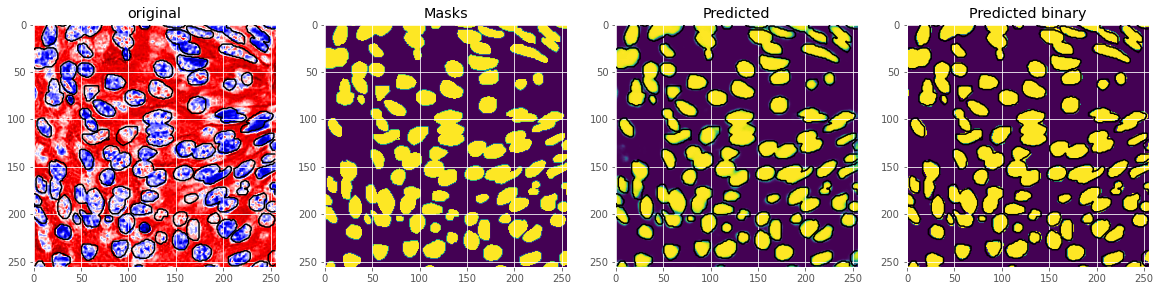

In [26]:
# Check if training data looks all right
plot_sample(X, y, preds_train, preds_train_t, ix=14)

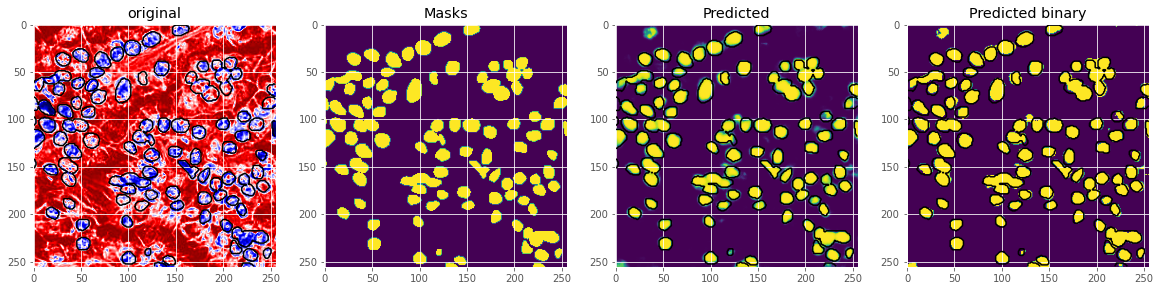

In [27]:
plot_sample(X, y, preds_train, preds_train_t)

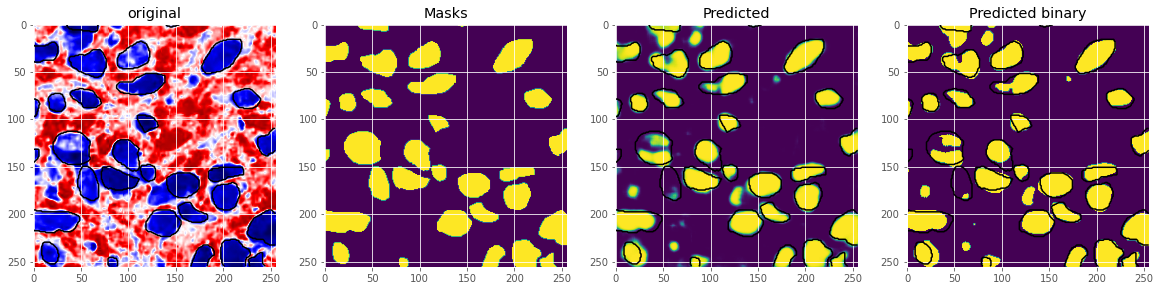

In [28]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=10)

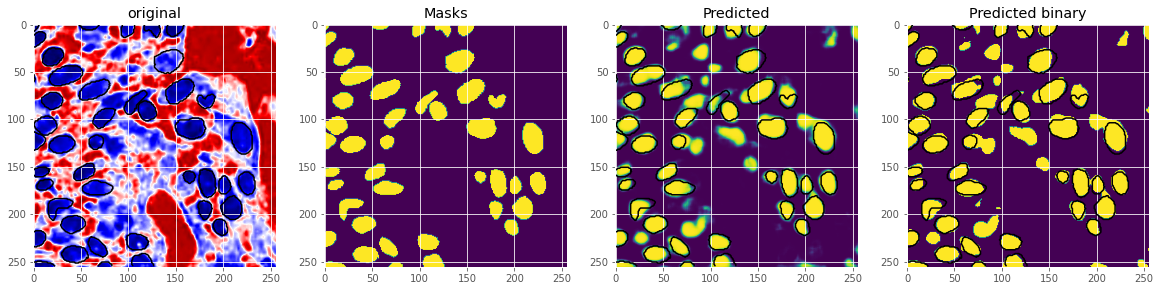

In [29]:
plot_sample(X_test, y_test, preds_test, preds_test_t)